**This notebook shows how to run the inference in the training-time two-view settings on the validation or training set of MegaDepth to visualize the training metrics and losses.**

In [1]:
%load_ext autoreload
%autoreload 2

import torch
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from omegaconf import OmegaConf

from pixloc import run_Aachen
from pixloc.pixlib.datasets.megadepth import MegaDepth
from pixloc.pixlib.utils.tensor import batch_to_device, map_tensor
from pixloc.pixlib.utils.tools import set_seed
from pixloc.pixlib.utils.experiments import load_experiment
from pixloc.visualization.viz_2d import (
    plot_images, plot_keypoints, plot_matches, cm_RdGn,
    features_to_RGB, add_text)

torch.set_grad_enabled(False);
mpl.rcParams['image.interpolation'] = 'bilinear'

# Create a validation or training dataloader

In [2]:
conf = {
    'min_overlap': 0.4,
    'max_overlap': 1.0,
    'max_num_points3D': 512,
    'force_num_points3D': True,
    
    'resize': 512,
    'resize_by': 'min',
    'crop': 512,
    'optimal_crop': True,
    
    'init_pose': [0.75, 1.],
#     'init_pose': 'max_error',
#     'init_pose_max_error': 4,
#     'init_pose_num_samples': 50,
    
    'batch_size': 1,
    'seed': 1,
    'num_workers': 0,
}
loader = MegaDepth(conf).get_data_loader('val', shuffle=True)
orig_items = loader.dataset.items

[09/22/2022 22:07:19 pixloc.pixlib.datasets.base_dataset INFO] Creating dataset MegaDepth
[09/22/2022 22:07:19 pixloc.pixlib.datasets.megadepth INFO] Sampling new images or pairs with seed 1
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 77/77 [00:10<00:00,  7.08it/s]


# Load the training experiment

In [3]:
# Name of the example experiment. Replace with your own training experiment.
exp = run_Aachen.experiment
device = 'cuda'
conf = {
    'optimizer': {'num_iters': 20,},
}
refiner = load_experiment(exp, conf).to(device)
print(OmegaConf.to_yaml(refiner.conf))

[09/22/2022 22:07:30 pixloc.pixlib.utils.experiments INFO] Loading checkpoint checkpoint_best.tar


name: two_view_refiner
trainable: true
freeze_batch_normalization: false
extractor:
  name: unet
  encoder: vgg19
  decoder:
  - 64
  - 64
  - 64
  - 32
  output_scales:
  - 0
  - 2
  - 4
  output_dim:
  - 32
  - 128
  - 128
  freeze_batch_normalization: false
  do_average_pooling: false
  compute_uncertainty: true
  checkpointed: true
optimizer:
  name: learned_optimizer
  num_iters: 20
  pad: 2
  lambda_: 0.01
  verbose: false
  loss_fn: scaled_barron(0, 0.1)
  no_conditions: true
  jacobi_scaling: false
  sqrt_diag_damping: false
  bound_confidence: true
  learned_damping: true
  damping:
    type: constant
duplicate_optimizer_per_scale: true
success_thresh: 3
clamp_error: 50
normalize_features: true
normalize_dt: true
init_target_offset: null



# Run on a few examples

- Reference image: red/green = reprojections of 3D points not/visible in the query at the ground truth pose
- Query image: red/blue/green = reprojections of 3D points at the initial/final/GT poses
- ΔP/ΔR/Δt are final errors in terms of 2D reprojections, rotation, and translation

ΔP 16.09 -> 49.653 px;  ΔR 2.97 -> 3.000 deg;  Δt 0.15 -> 0.503 %m
ΔP 16.11 -> 6.772 px;  ΔR 1.60 -> 0.545 deg;  Δt 0.22 -> 0.971 %m
ΔP 3.39 -> 20.355 px;  ΔR 1.72 -> 3.486 deg;  Δt 0.20 -> 0.232 %m
ΔP 1.54 -> 50.000 px;  ΔR 0.42 -> 6.487 deg;  Δt 0.05 -> 2.110 %m
ΔP 1.40 -> 25.542 px;  ΔR 0.60 -> 1.820 deg;  Δt 0.06 -> 0.133 %m


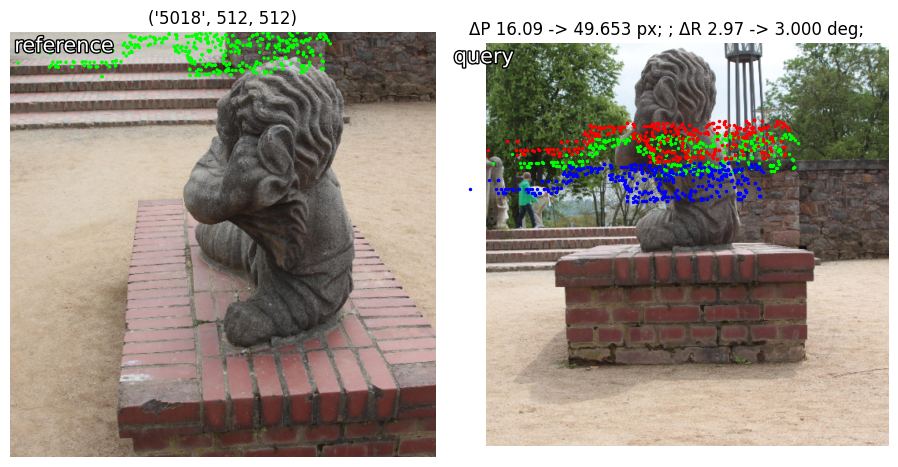

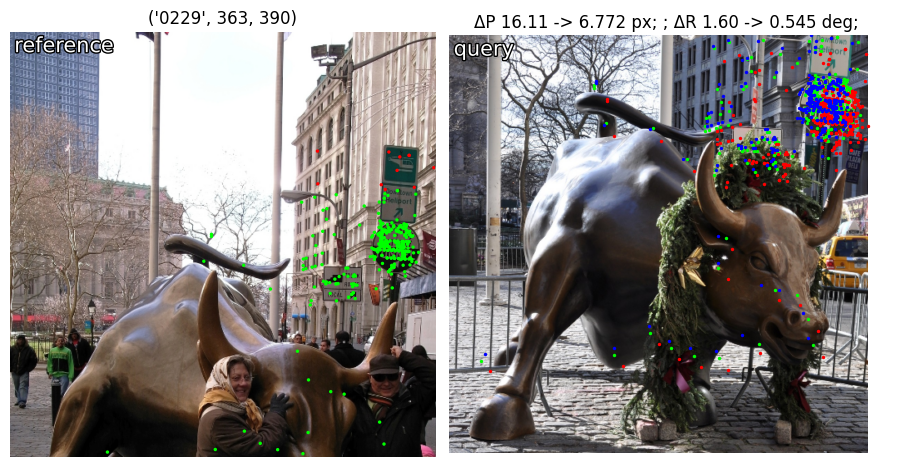

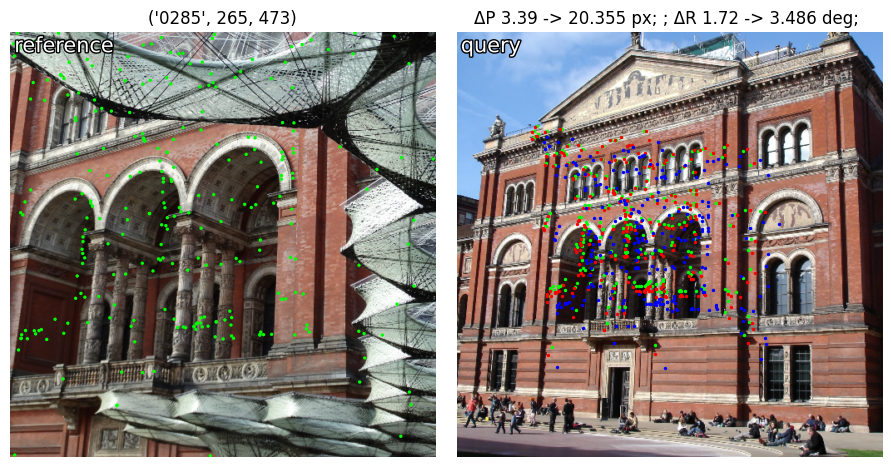

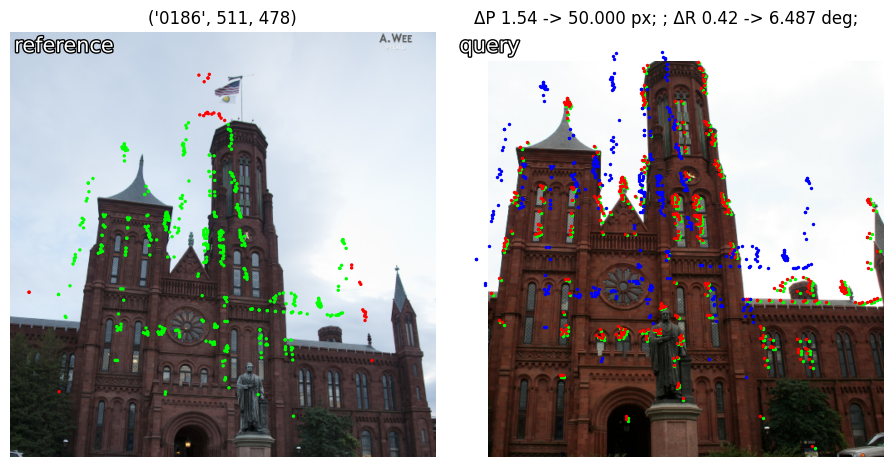

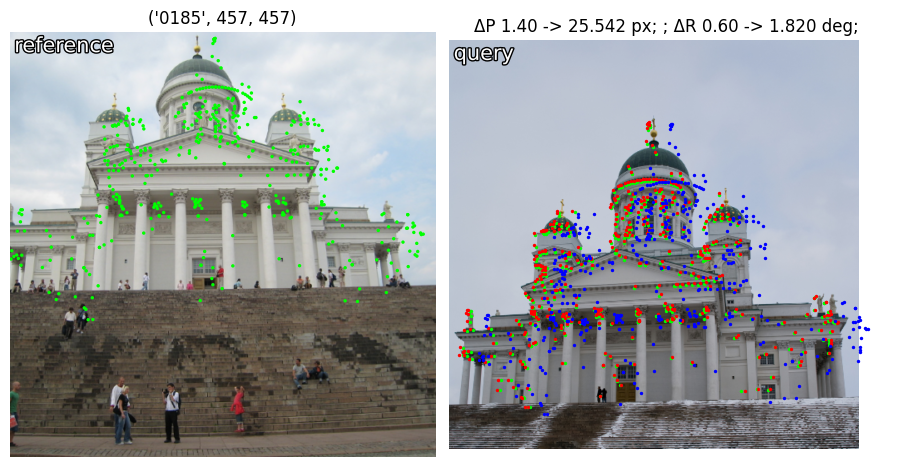

In [4]:
set_seed(7)
for _, data in zip(range(5), loader):
    data_ = batch_to_device(data, device)
    pred_ = refiner(data_)
    pred = map_tensor(pred_, lambda x: x[0].cpu())
    data = map_tensor(data, lambda x: x[0].cpu())
    cam_q = data['query']['camera']
    p3D_r = data['ref']['points3D']
        
    p2D_r, valid_r = data['ref']['camera'].world2image(p3D_r)
    p2D_q_gt, valid_q = cam_q.world2image(data['T_r2q_gt'] * p3D_r)
    p2D_q_init, _ = cam_q.world2image(data['T_r2q_init'] * p3D_r)
    p2D_q_opt, _ = cam_q.world2image(pred['T_r2q_opt'][-1] * p3D_r)
    valid = valid_q & valid_r
    
    losses = refiner.loss(pred_, data_)
    mets = refiner.metrics(pred_, data_)
    errP = f"ΔP {losses['reprojection_error/init'].item():.2f} -> {losses['reprojection_error'].item():.3f} px; "
    errR = f"ΔR {mets['R_error/init'].item():.2f} -> {mets['R_error'].item():.3f} deg; "
    errt = f"Δt {mets['t_error/init'].item():.2f} -> {mets['t_error'].item():.3f} %m"
    print(errP, errR, errt)

    imr, imq = data['ref']['image'].permute(1, 2, 0), data['query']['image'].permute(1, 2, 0)
    plot_images([imr, imq],titles=[(data['scene'][0], valid_r.sum().item(), valid_q.sum().item()), errP+'; '+errR])
    plot_keypoints([p2D_r[valid_r], p2D_q_gt[valid]], colors=[cm_RdGn(valid[valid_r]), 'lime'])
    plot_keypoints([np.empty((0, 2)), p2D_q_init[valid]], colors='red')
    plot_keypoints([np.empty((0, 2)), p2D_q_opt[valid]], colors='blue')
    add_text(0, 'reference')
    add_text(1, 'query')

    continue
    for i, (F0, F1) in enumerate(zip(pred['ref']['feature_maps'], pred['query']['feature_maps'])):
        C_r, C_q = pred['ref']['confidences'][i][0], pred['query']['confidences'][i][0]
        plot_images([C_r, C_q], cmaps=mpl.cm.turbo)
        add_text(0, f'Level {i}')
            
        axes = plt.gcf().axes
        axes[0].imshow(imr, alpha=0.2, extent=axes[0].images[0]._extent)
        axes[1].imshow(imq, alpha=0.2, extent=axes[1].images[0]._extent)
        plot_images(features_to_RGB(F0.numpy(), F1.numpy(), skip=1))